## Quantum algorithm for Boltzmann Solver

In [39]:
import numpy as np
from qiskit import *
import scipy.linalg
from qiskit.quantum_info.operators import Operator
import math
from qiskit.visualization import plot_histogram
from model.quantumcalc import *
from model.classes import *
from model.constants import *
from itertools import product
from qiskit.circuit.library import MCXGate
from qiskit.quantum_info import Statevector

# import parameters as para
%reload_ext autoreload
%autoreload 2

## 0. Defining parameters and the quantum circuit

In [40]:
qubit_mesh = 2

mesh = Mesh(x=qubit_mesh,y=qubit_mesh,z=qubit_mesh,vx=qubit_mesh,vy=qubit_mesh,vz=qubit_mesh)

geo = Geometry(x=qubit_mesh,y=qubit_mesh,z=qubit_mesh,vx=qubit_mesh,vy=qubit_mesh,vz=qubit_mesh)

print(mesh.x)
print(geo.volume)
print(mesh.data())
#xyz
print(geo.length()[:len(geo.length())//2])
#xyzvxvyvz
print(geo.length())

2
4096
[2, 2, 2, 2, 2, 2]
[4, 4, 4]
[4, 4, 4, 4, 4, 4]


In [41]:
N = Number_of_qubits(n_phys=qubit_mesh*6,n_order=0,n_species=0,n_subnode=4,n_ancila=1)
print(N.phys,N.ancila,N.sub,N.control,N.total)
print(N.data)

12 1 4 5 17
[12, 0, 0, 4, 1]


In [43]:
exec(Nloops(geo.length(),operation_name='loop_prod_6dim'))
exec(Nloops(geo.length()[:len(geo.length())//2],operation_name='loop_prod_3dim'))

In [44]:
f_ion=np.ones(geo.length())
f_elec=np.ones(geo.length())
#初期条件x=y=1,vx=vy=1で0
f_ion[1,1,:,:,:,:]=0
f_ion[:,:,:,1,1,:]=0
#初期条件x=y=max-1,vx=vy=max-1で0
f_elec[2**mesh.x-2,2**mesh.y-2,:,:,:,:]=0
f_elec[:,:,:,2**mesh.vx-2,2**mesh.vy-2,:]=0

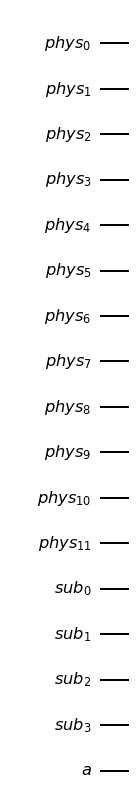

In [45]:
base_circuit = Calculation_circuit(N.data)
regs = Registers()
QC=base_circuit.generate(regs)
QC.draw('mpl')


## 1. Encoding

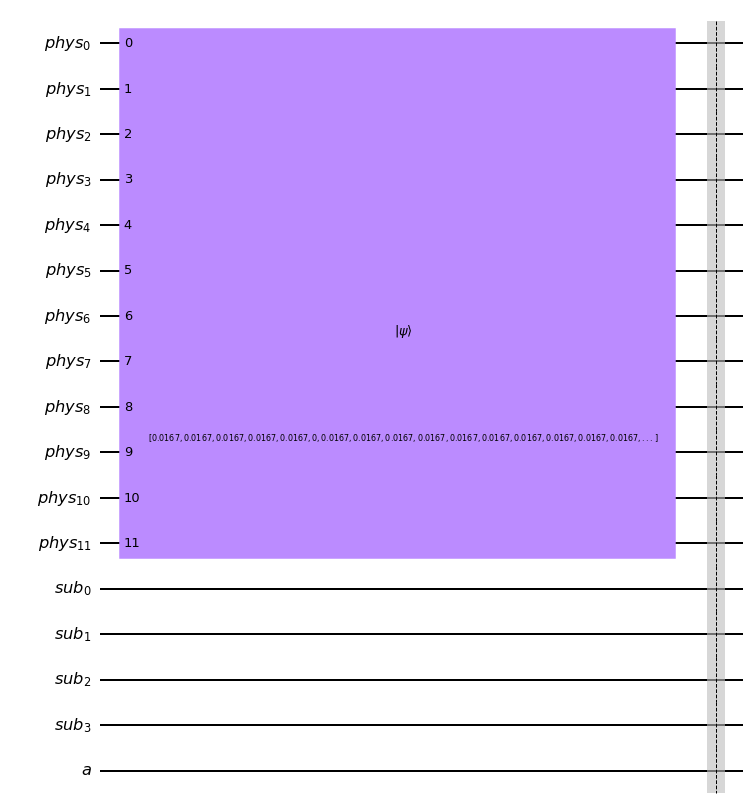

In [46]:
#物理量をエンコードする
f_tilda=np.ones(geo.volume)#ionとelecの分布をそれぞれ入れる

for ix, iy, iz, ivx, ivy, ivz in loop_prod_6dim:
    f_tilda[ivz*2**(mesh.x+mesh.y+mesh.z+mesh.vx+mesh.vy)+ivy*2**(mesh.x+mesh.y+mesh.z+mesh.vx)+ivx*2**(mesh.x+mesh.y+mesh.z)+iz*2**(mesh.x+mesh.y)+iy*2**mesh.x+ix] \
    = f_ion[ix,iy,iz,ivx,ivy,ivz]
    #f_tilda[2**(mesh.x+mesh.y+mesh.z+mesh.vx+mesh.vy+mesh.vz)+ivz*2**(mesh.x+mesh.y+mesh.z+mesh.vx+mesh.vy)+ivy*2**(mesh.x+mesh.y+mesh.z+mesh.vx)+ivx*2**(mesh.x+mesh.y+mesh.z)+iz*2**(mesh.x+mesh.y)+iy*2**mesh.x+ix] \
    #= f_elec[ix,iy,iz,ivx,ivy,ivz]
    
fac=[]
f_tilda = normalized(f_tilda,fac)                        
QC.initialize(f_tilda, regs.phys)#+regs.species)
QC.barrier()
QC.draw('mpl')


## 2. Propagation(Quantum Walk)

Coin演算子のfactor行列を作る

In [47]:
#import Maxwellsolver
file_name = 'output_Maxwell.bin'
state = np.fromfile(file_name,dtype=np.float64)
#print(np.shape(state))

Ex = get_Maxwell_res(state=state,species='E',direction='x',qubit_mesh=qubit_mesh)
Ey = get_Maxwell_res(state=state,species='E',direction='y',qubit_mesh=qubit_mesh)
Ez = get_Maxwell_res(state=state,species='E',direction='z',qubit_mesh=qubit_mesh)
vBx = get_Maxwell_res(state=state,species='B',direction='x',qubit_mesh=qubit_mesh)
vBy = get_Maxwell_res(state=state,species='B',direction='y',qubit_mesh=qubit_mesh)
vBz = get_Maxwell_res(state=state,species='B',direction='z',qubit_mesh=qubit_mesh)

Ex=Ex/2.10305430e-04
Ey=Ey/2.10305430e-04
Ez=Ey/2.10305430e-04
vBx=vBx/2.10305430e-04
vBy=vBy/2.10305430e-04
vBz=vBz/2.10305430e-04


factor = np.ones((2**(N.sub+mesh.x+mesh.y+mesh.z)))
#各係数を代入
#ft、fx+1、fx-1、fy+1、fy-1、fz+1、fz-1、fvx+1、fvx-1、fvy+1、fvy-1、fvz+1、fvz-1、余り①、余り②、余り③の順で配置
#ftの係数1
#fx+1の係数1
#fx-1の係数1
#fy+1の係数1
#fy-1の係数1
#fz+1の係数1
#fz-1の係数1
#fvx+1の係数
#fvx-1の係数
for sub in range(7,9):
    for i in range(len(Ex)):
        factor[sub*2**(mesh.x+mesh.y+mesh.z)+i]= (e/me)*(Ex[i]+vBx[i])*Δt/(2*Δvx)#ExとvxBxに依存
#fvy+1の係数
#fvy-1の係数
for sub in range(9,11):
    for i in range(len(Ey)):
        factor[sub*2**(mesh.x+mesh.y+mesh.z)+i] = (e/me)*(Ey[i]+vBy[i])*Δt/(2*Δvy)#EyとvxByに依存
#fvz+1の係数
#fvz-1の係数
for sub in range(11,13):
    for i in range(len(Ez)):
        factor[sub*2**(mesh.x+mesh.y+mesh.z)+i] = (e/me)*(Ez[i]+vBz[i])*Δt/(2*Δvz)#EzとvxBzに依存
#余り①
#余り②
#余り③
for sub in range(13,16):
    for i in range(len(Ex)):
        factor[sub*2**(mesh.x+mesh.y+mesh.z)+i] = 0

Coin演算子を作用させる

[0, 1, 2, 3, 4, 5, Qubit(QuantumRegister(4, 'sub'), 0), Qubit(QuantumRegister(4, 'sub'), 1), Qubit(QuantumRegister(4, 'sub'), 2), Qubit(QuantumRegister(4, 'sub'), 3)]


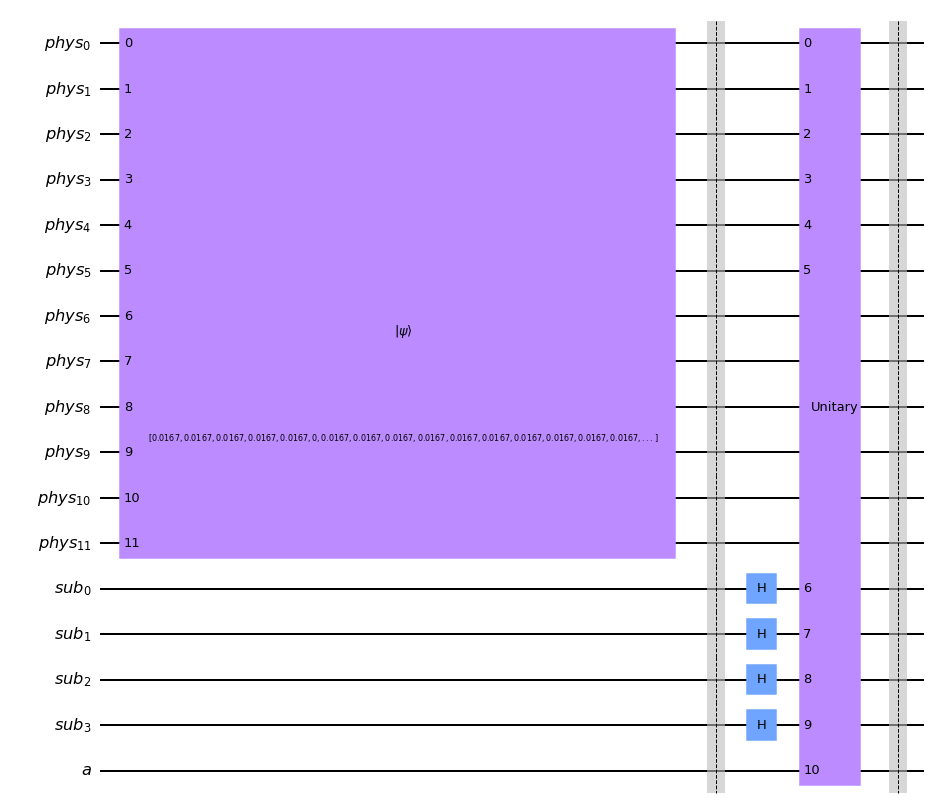

In [48]:
QC.h(regs.sub)
#Coin演算子
#差分方程式の係数
coefs=factor
xyz = [i for i in range(mesh.x+mesh.y+mesh.z)]
sites=xyz+regs.sub
#print(sites)
anc=-1
fac=[]
QC = apply_Bope(coefs,QC,sites,anc,fac)
fac_normkeisu = fac[0]


QC.barrier()
QC.draw('mpl')

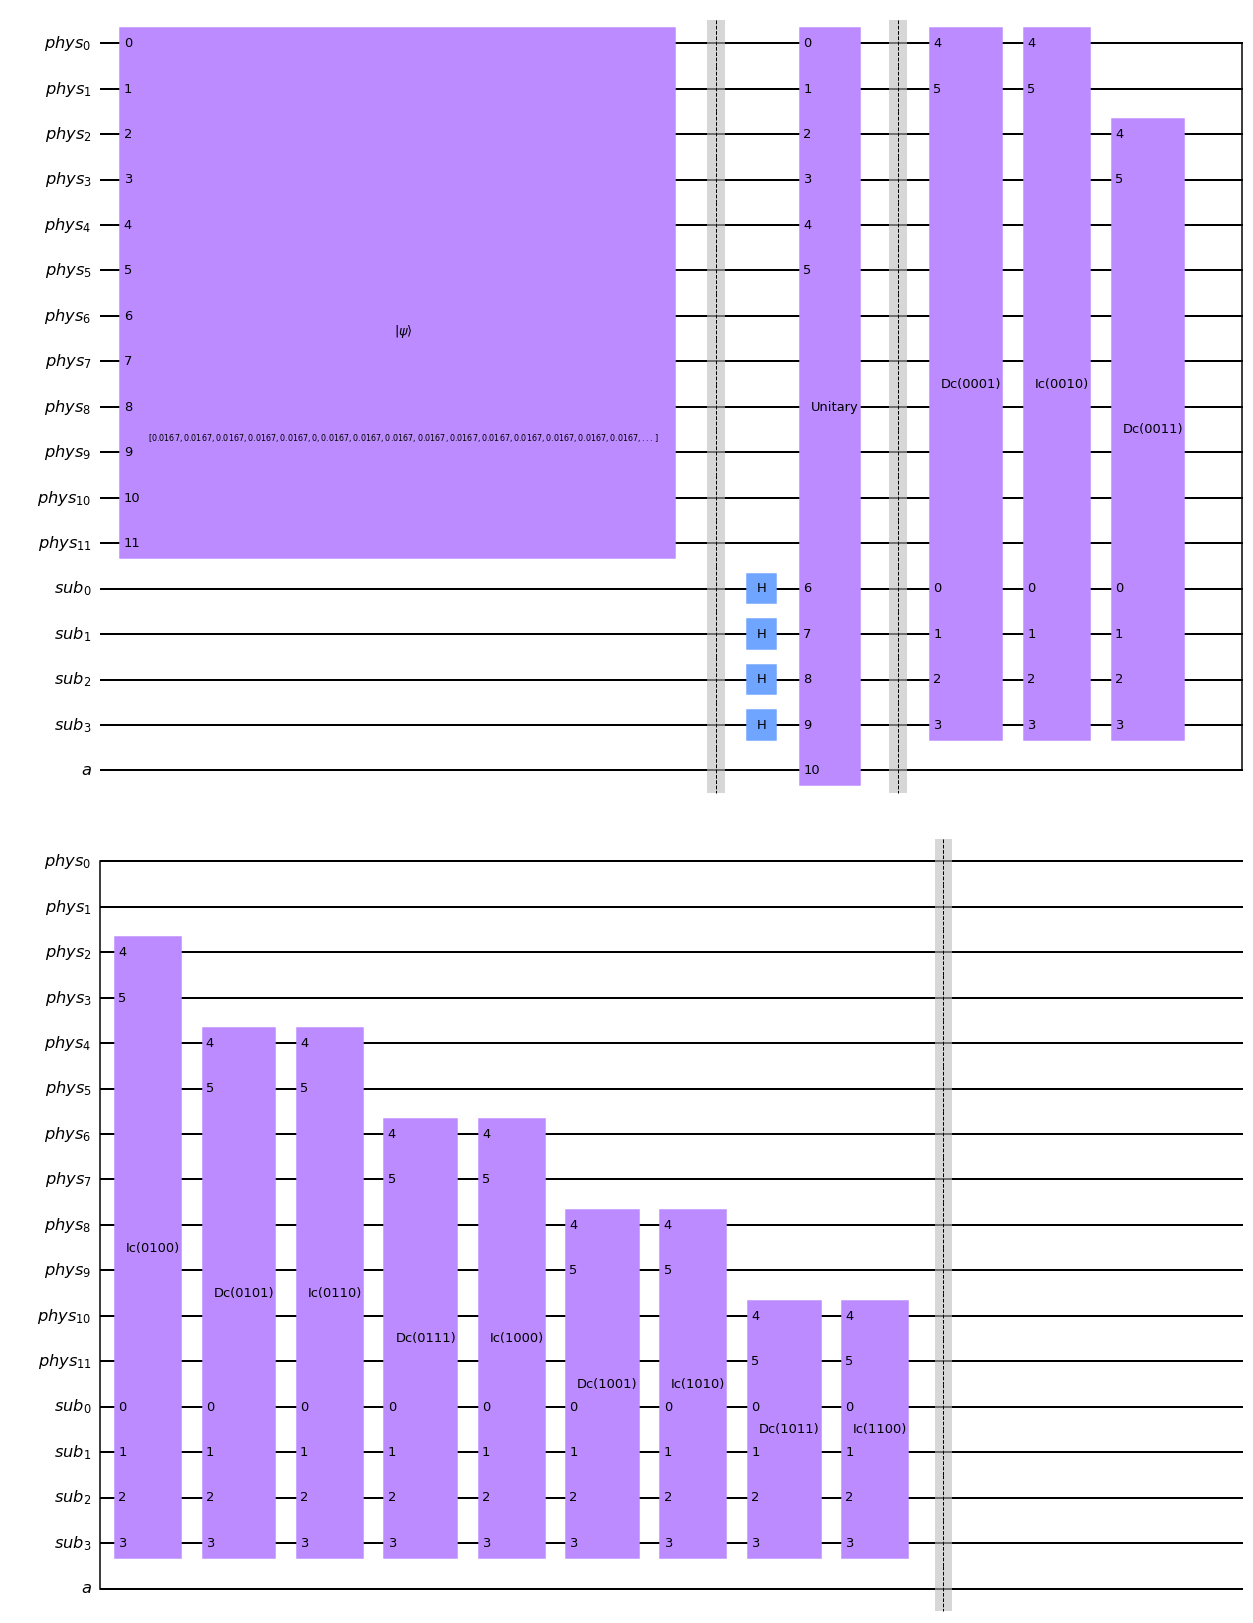

In [49]:
state_space_relation = {
    0:'f',
    1:'0+',
    2:'0-',
    3:'1+',
    4:'1-',
    5:'2+',
    6:'2-',
    7:'3+',
    8:'3-',
    9:'4+',
    10:'4-',
    11:'5+',
    12:'5-',
    13:'*',
    14:'*',
    15:'*'
}
## ↑0:x,　1:y,　2:z,　3:vx,　4:vy,　5:vz,　*:あまり

for i in range(2**N.sub):
    direction = state_space_relation[i]
    if direction == 'f' or direction == '*':
        continue
    num_space = int(direction[0])
    sign = direction[1]

    ctrl_state = bin(i)[2:].zfill(N.sub)[::-1]
    if sign == '+':
        I_D = control_decre(num_ctrl=N.sub,num_target=qubit_mesh,state=ctrl_state)
    else:
        I_D = control_incre(num_ctrl=N.sub,num_target=qubit_mesh,state=ctrl_state)
    QC.append(I_D,regs.sub+regs.phys[qubit_mesh*num_space:qubit_mesh*(num_space+1)])
QC.barrier()
QC.draw('mpl')


## 3. Integration

### 3-1 反転

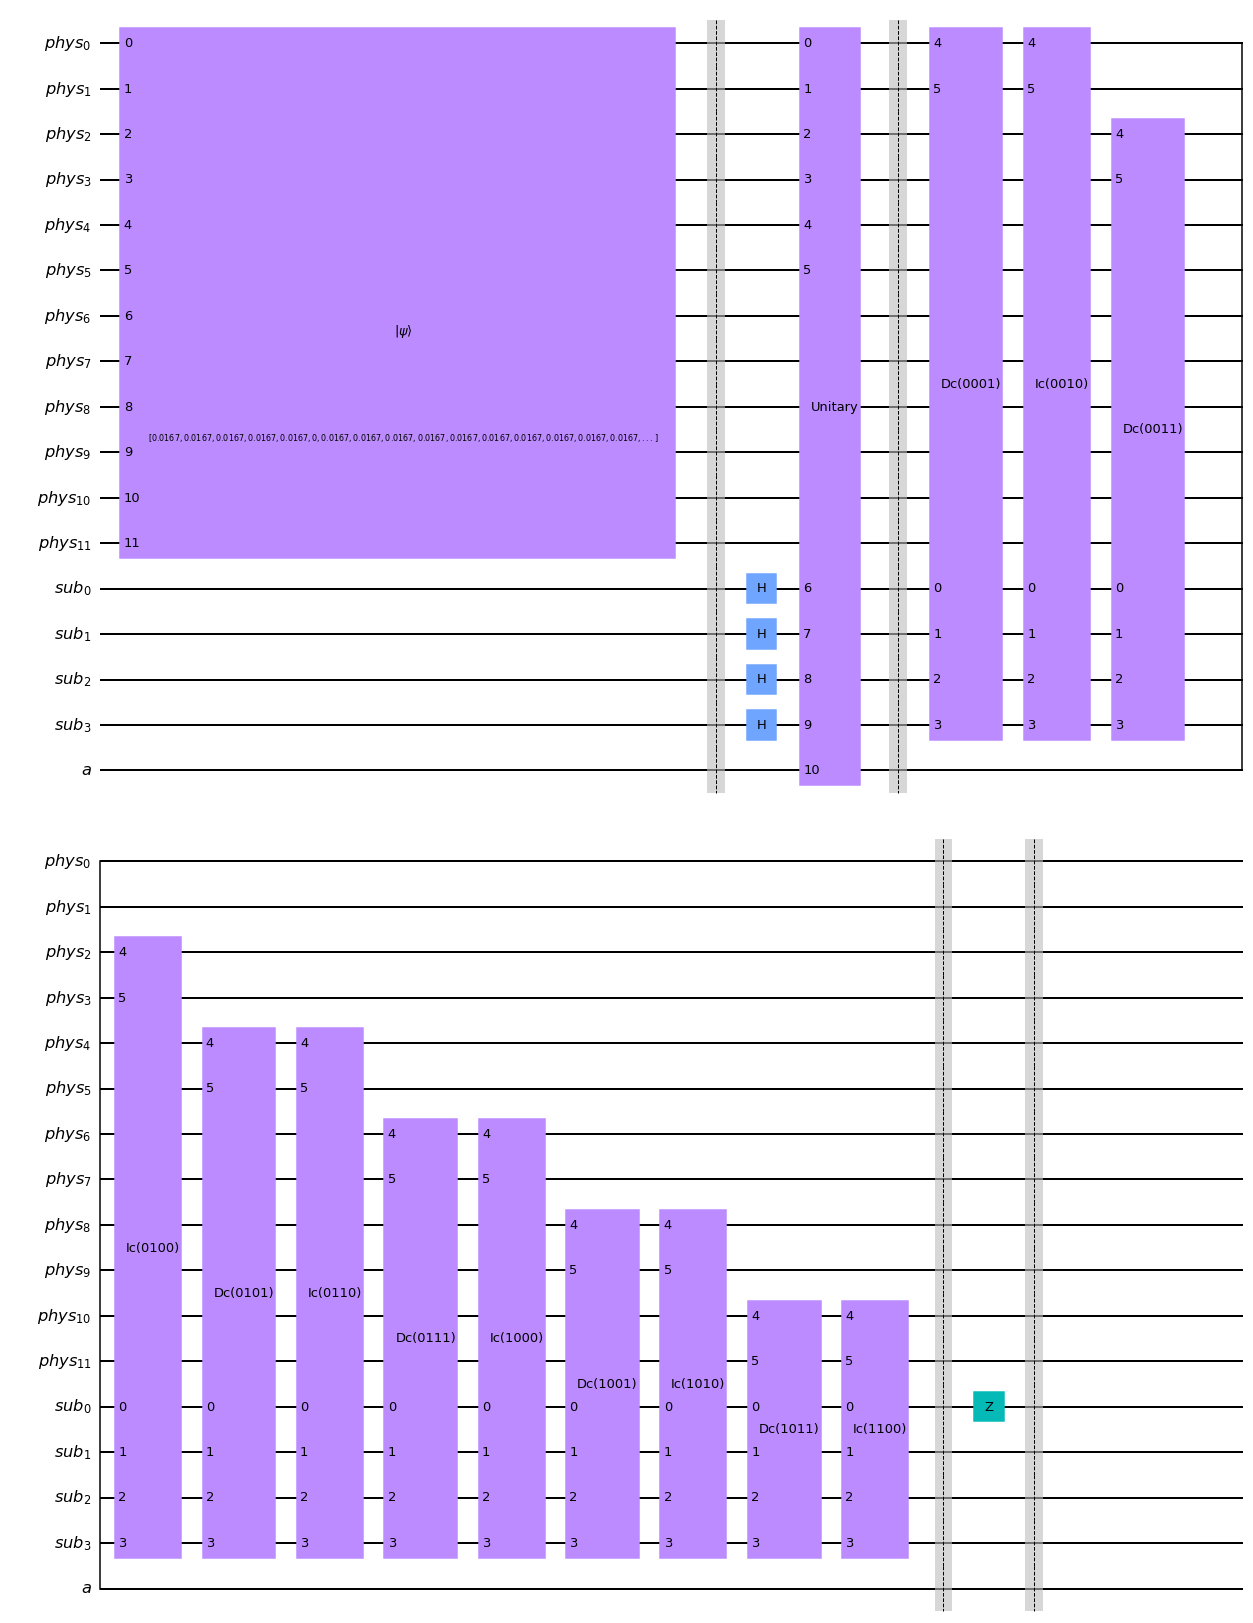

In [50]:
#反転オラクルを用いる
QC.z(regs.sub[0])

QC.barrier()

QC.draw('mpl')

### 3-2 和の回路

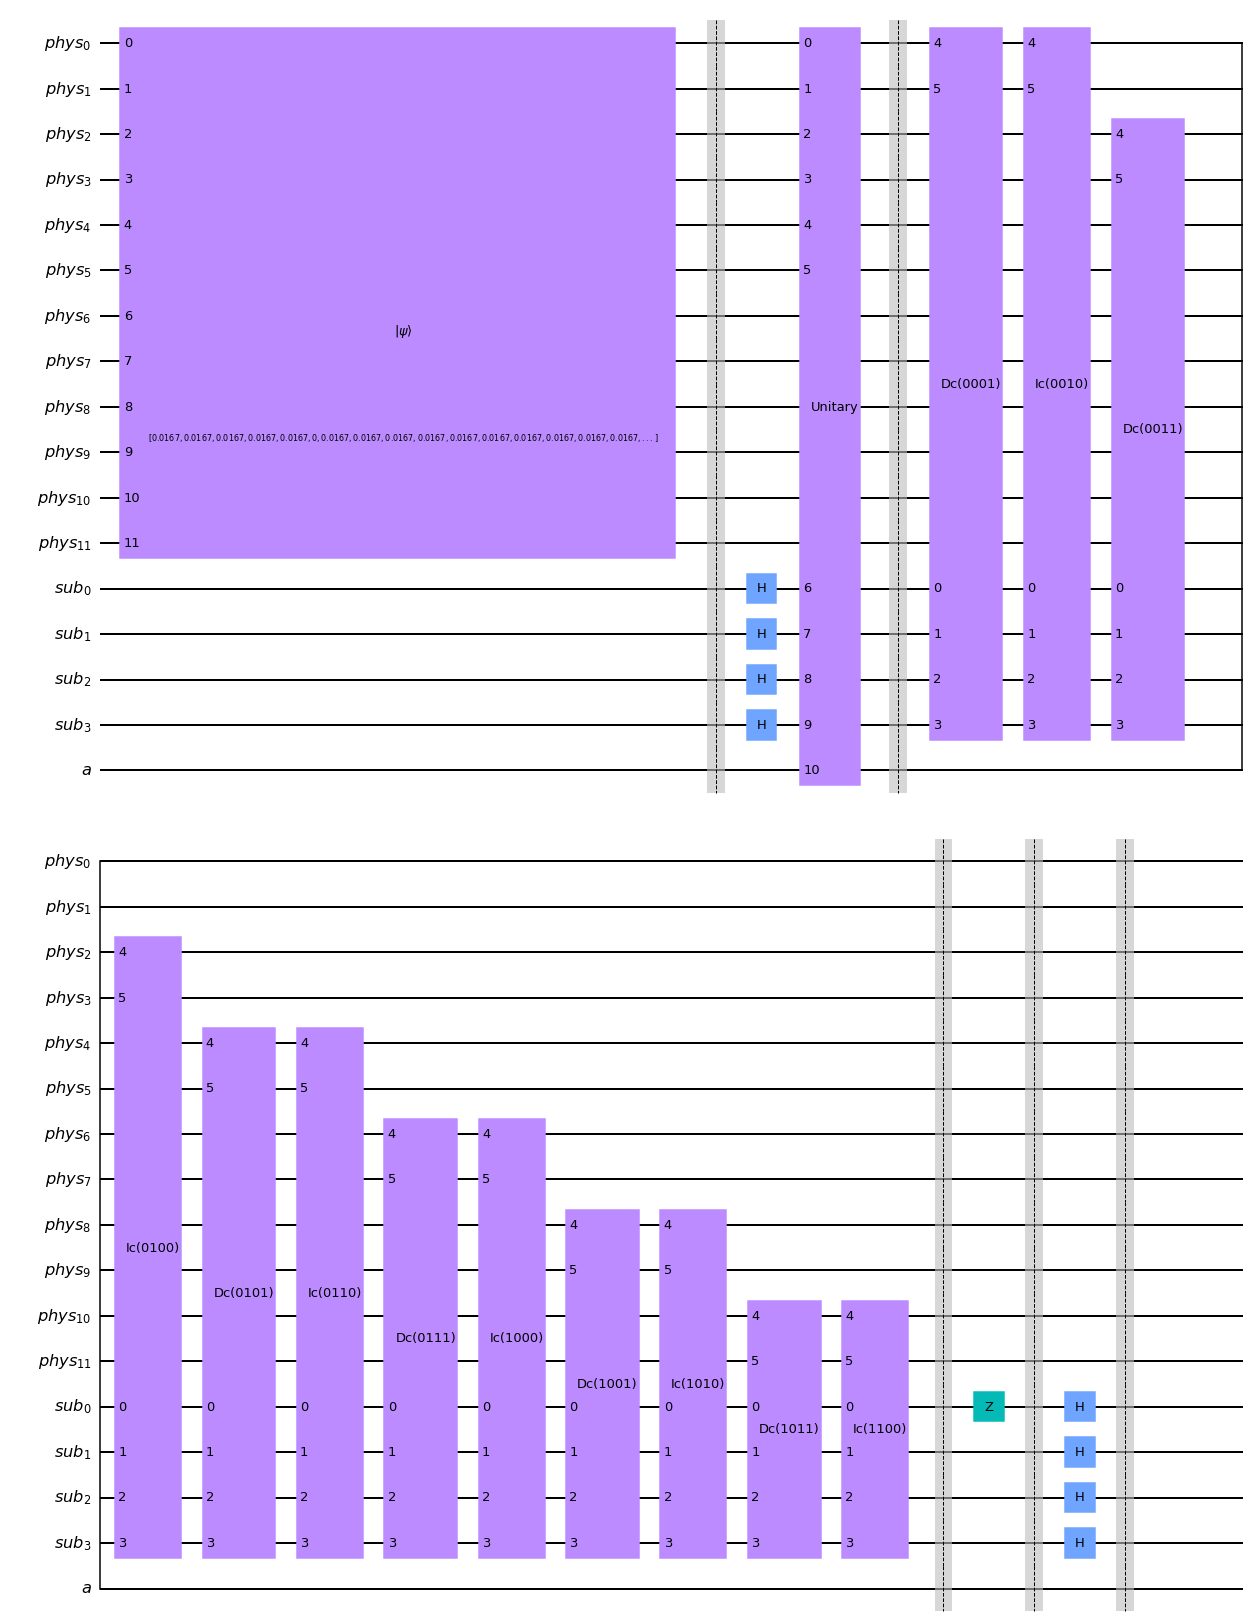

In [51]:
QC.h(regs.sub)
QC.barrier()
QC.draw('mpl')